In [1]:
import numpy as np

from devito.logger import info
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import Model, PointSource, Receiver
from devito import clear_cache, TimeFunction, Operator, Function
from devito.logger import set_log_level
from sympy import Eq, solve, cos, sin, sqrt,exp, diff
from opescibench import LinePlotter

import matplotlib.pyplot as plt
from matplotlib import cm

In [227]:

class ModelBench(Model):
    """
    Physical model used for accuracy benchmarking,
    all is the same as a model except the critical dt
    made small enough to ignore
    time discretization errors
    """

    @property
    def critical_dt(self):
        """Critical computational time step value from the CFL condition."""
        # For a fixed time order this number goes down as the space order increases.
        #
        # The CFL condtion is then given by
        # dt <= coeff * h / (max(velocity))
        coeff = 0.38 if len(self.shape) == 3 else 0.42
        return .1*self.spacing[0]/self.vp

# Manufacture solution

https://arxiv.org/pdf/1702.01383.pdf

x/sqrt(x)*exp(-(pi f0) (r(x,z) - at)^2) - exp(-(pi f0) (r(x,z) - a2 t)^2)

In [228]:
def d1(xx, size, order):
    exponent = order/2
    roots = np.linspace(float(exponent)/size, 2.0-float(exponent)/size, order)
    xno = 2.0*xx/size
    return 1e3*np.prod([(xno-r) for r in roots])

def mms(h, nn, spc, nt, c0=580):
    clear_cache()
    set_log_level("ERROR")

    modelloc = ModelBench(vp=c0, origin=(0., 0.), spacing=(h, h), shape=(nn, nn), nbpml=spc, dtype=np.float64)
    dt = modelloc.critical_dt

    # Create symbols for forward wavefield, source and receivers
    u = TimeFunction(name='u', grid=modelloc.grid, save=nt,
                     time_order=2, space_order=spc)
    anlytic = TimeFunction(name='anlytic', grid=modelloc.grid, space_order=spc, save=nt)

    s = modelloc.grid.stepping_dim.spacing
    x, y = modelloc.grid.dimensions
    sol = (d1(x, modelloc.shape_domain[0], 8) *
           d1(y, modelloc.shape_domain[1], 8) *
           sin(modelloc.grid.time_dim*s/(nt+25)))
    source_term = (1.0/c0**2 * diff(sol, modelloc.grid.time_dim, 2) -
                   diff(sol, modelloc.grid.dimensions[0], 2) -
                   diff(sol, modelloc.grid.dimensions[1], 2))

    stencil = [Eq(u.forward, 2.0 * u - u.backward + c0**2 * s**2 * u.laplace + c0**2 * s**2 * source_term)]
    analytical = [Eq(anlytic, sol)]

    init_1 = [Eq(u.indexed[1, x, y], sol.subs({modelloc.grid.time_dim : 1.0}))]
    
    op = Operator(init_1 + stencil + analytical, dse='noop', dle='noop')
    summary = op.apply(dt=dt, time_s=0)
    return u, anlytic, summary, dt

# Verification

We compute the error between the numerical and analytical solutions for varying spatial discretization order and grid spacing. We also compare the time to solution to the erro for these parameters.

In [170]:

orders = ((2, ((401 , 1.0), (201, 2.0), (101, 4.0))),
           (4, ((401 , 1.0), (201, 2.0), (101, 4.0))),
           (8, ((401 , 1.0), (201, 2.0), (101, 4.0))))

# orders = ((2, ((401 , 2.0), (251, 3.2), (201, 4.0))),
#            (4, ((251, 3.2), (201, 4.0), (101, 8.0))),
#            (8, ((201, 4.0), (101, 8.0), (51, 16.0))))
nt = 500

In [180]:
errorl2 = np.zeros((3, 3))
timing = np.zeros((3, 3))


ind_o = -1
for order, gr in orders:
    ind_o +=1
    ind_spc = -1
    for nn, h in gr:
        ind_spc += 1
        clear_cache()
        u, analytical, summary, dt = mms(h, nn, order, nt)
        spc = order+1
        errorl2[ind_o, ind_spc] = np.max(np.fabs(u.data[nt-1, spc:-spc, spc:-spc] -
                                                   analytical.data[nt-1, spc:-spc, spc:-spc]))
        timing[ind_o, ind_spc] = summary.timings['main']
        print("starting space order %s with (%s, %s) grid points the error is %s for %s runtime" %
              (order, nn, nn, errorl2[ind_o, ind_spc], timing[ind_o, ind_spc]))
        
        
        

starting space order 2 with (401, 401) grid points the error is 0.000135500451225 for 1.503938 runtime
starting space order 2 with (201, 201) grid points the error is 0.000733646376419 for 0.398683 runtime
starting space order 2 with (101, 101) grid points the error is 1.90365546013e-05 for 0.104527 runtime


KeyboardInterrupt: 

In [42]:
stylel = ('-^k', '-^b', '-^r', '-^g', '-^c')

ord = [2, 4, 8]

dx = [1.0, 2.0, 4.0]
with LinePlotter(figname='MyPrettyPicture.pdf', plotdir='./',  xlabel='error') as plot:
    for i in range(0, 3):
        plot.add_line(list(errorl2[i, :]), list(timing[i, :]), label=('order %s' % ord[i]), style=stylel[i],
                      annotations=[('dx = %s m' % (sc)) for sc in dx][0:3])

plt.clf()
from IPython.display import IFrame
IFrame("MyPrettyPicture.pdf", width=600, height=600)

OpesciBench: Plotting ./MyPrettyPicture.pdf 


In [43]:
print(timing)

[[ 1.493273  0.390173  0.104743]
 [ 2.255157  0.537625  0.173685]
 [ 6.828573  1.803355  0.493528]]


In [44]:
print(errorl2)

[[  2.08409423e-03   3.16498401e-01   4.61203990e+00]
 [  1.76119286e-04   2.54118973e-01   2.90795283e+00]
 [  4.47278661e-05   1.43348573e-01   7.54290372e-01]]


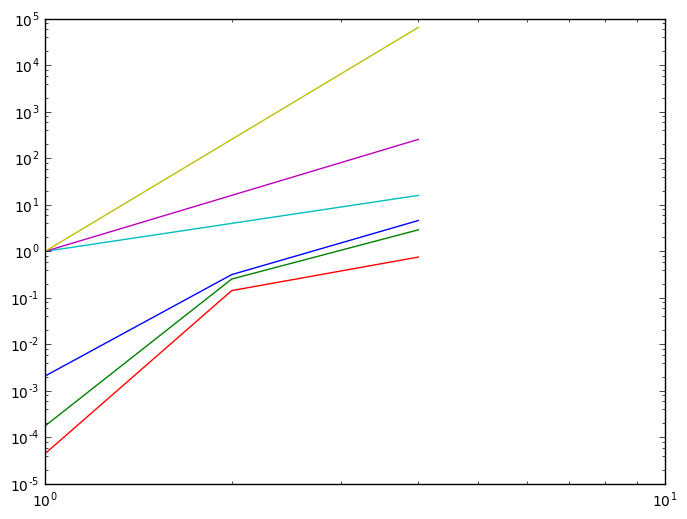

In [45]:
plt.figure()
plt.loglog([1.0, 2.0, 4.0], errorl2[0,:])
plt.loglog([1.0, 2.0, 4.0], errorl2[1,:])
plt.loglog([1.0, 2.0, 4.0], errorl2[2,:])
plt.loglog(dx, [dd**2 for dd in dx])
plt.loglog(dx, [dd**4 for dd in dx])
plt.loglog(dx, [dd**8 for dd in dx])
plt.show()

In [15]:
1.51512599e-04*16

0.002424201584

In [9]:
stylel = ('-^k', '-^b', '-^r', '-^g', '-^c')
style2 = ('--k', '--b', '--r', '--g', '--c')

with LinePlotter(figname='MyPrettyPicture3.pdf', plotdir='./',  xlabel='Grid size', ylabel = 'L2 error') as plot:
    for i in range(0, len(orders)):
        theory = [k**(orders[i]) for k in [2, 4, 6]][::-1]
        theory = [errorl2[-1,i]*th/theory[0] for th in theory]
        plot.add_line([sc for _, sc in sizes][::-1], list(errorl2[::-1, i]), label=('order %s' % orders[i]),
                      annotations=[('dx = %s m' % (sc)) for _, sc in sizes][::-1], style=stylel[i])
        plot.add_line([sc for _, sc in sizes][::-1], list(theory), style=style2[i])
plt.clf()
from IPython.display import IFrame
IFrame("MyPrettyPicture3.pdf", width=600, height=600)

ValueError: min() arg is an empty sequence

In [229]:
nt = 500
u1, analy1, _, _ = mms(1.0, 401, 2, nt)
u2, analy2, _, _ = mms(1.0, 401, 4, nt)
u3, analy3, _, _ = mms(1.0, 401, 8, nt)

# Plot

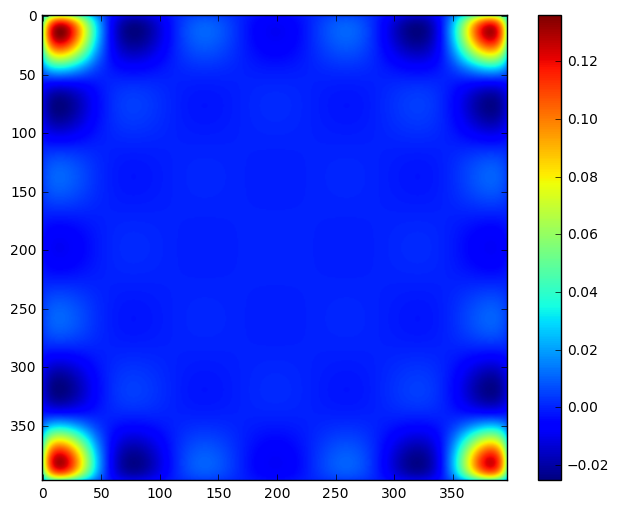

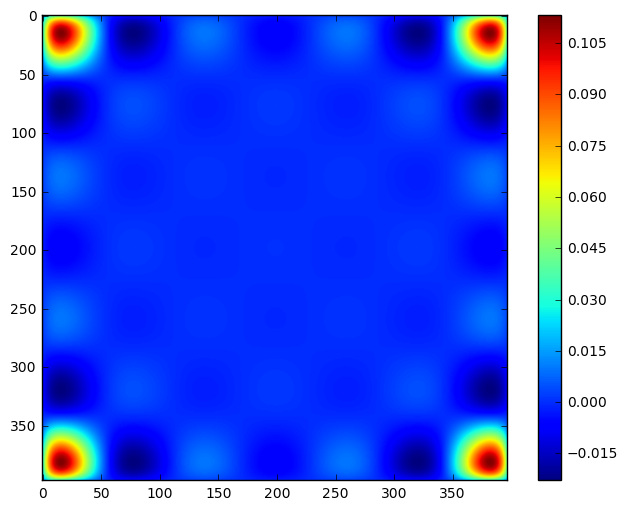

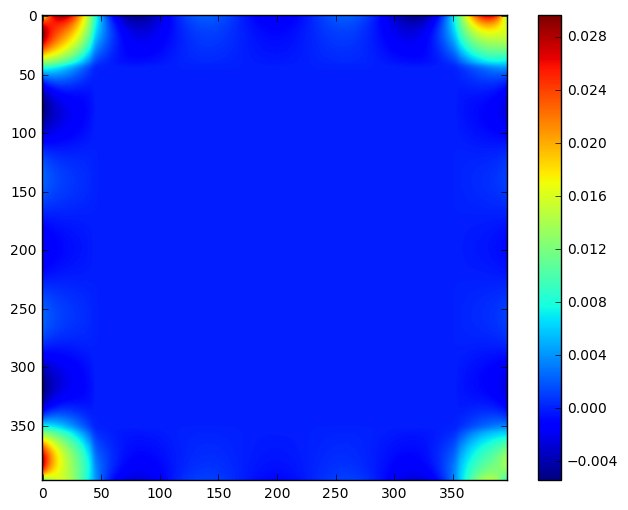

In [230]:
ti=nt-1
spc=2
plt.figure()
plt.imshow(u1.data[ti, 2*spc:-2*spc, 2*spc:-2*spc])
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(analy1.data[ti, 2*spc:-2*spc, 2*spc:-2*spc])
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(u1.data[ti, 2*spc:-2*spc, 2*spc:-2*spc] - analy1.data[ti, 2*spc:-2*spc, 2*spc:-2*spc])
plt.colorbar()
plt.show()

In [231]:
np.max(np.fabs((u1.data[ti, 2*spc:-2*spc, 2*spc:-2*spc] - analy1.data[ti, 2*spc:-2*spc, 2*spc:-2*spc])))

0.029589097006708035

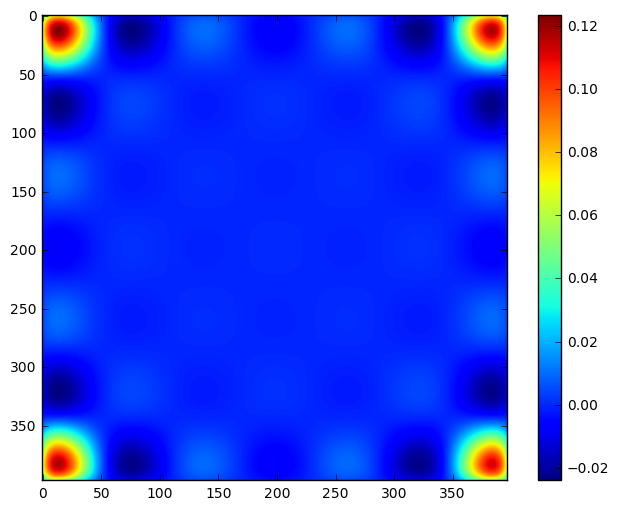

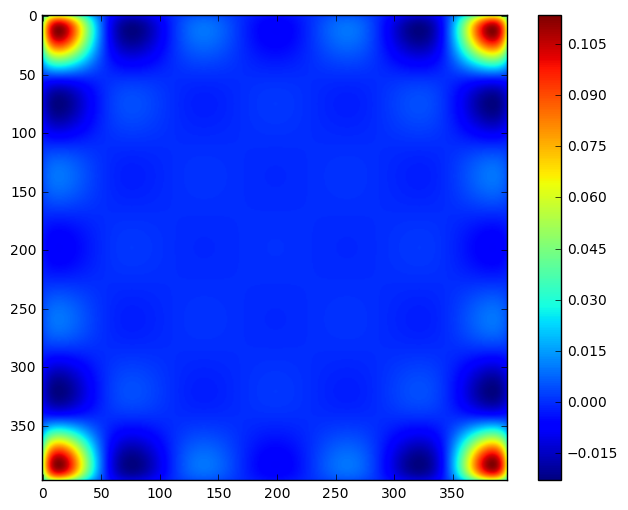

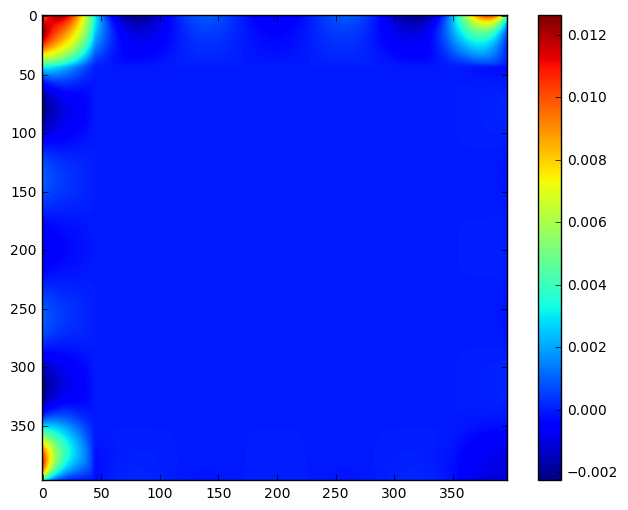

In [232]:
ti=nt-1
spc=3
plt.figure()
plt.imshow(u2.data[ti, 2*spc:-2*spc, 2*spc:-2*spc])
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(analy2.data[ti, 2*spc:-2*spc, 2*spc:-2*spc])
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(u2.data[ti, 2*spc:-2*spc, 2*spc:-2*spc] - analy2.data[ti, 2*spc:-2*spc, 2*spc:-2*spc])
plt.colorbar()
plt.show()

In [233]:
np.max(np.fabs((u2.data[ti, 2*spc:-2*spc, 2*spc:-2*spc] - analy2.data[ti, 2*spc:-2*spc, 2*spc:-2*spc])))

0.012611788674435222

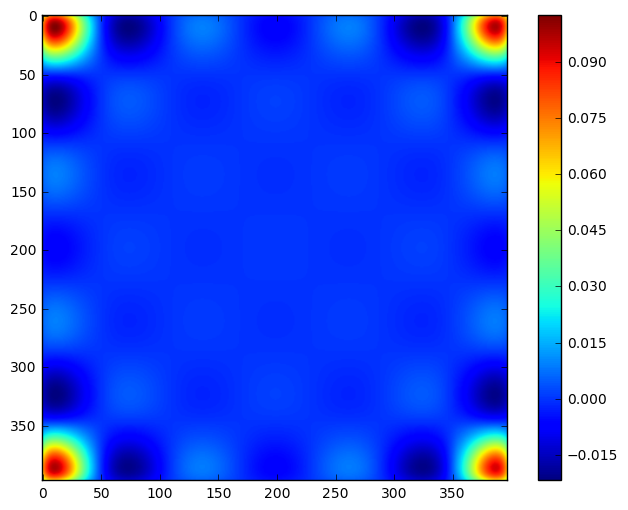

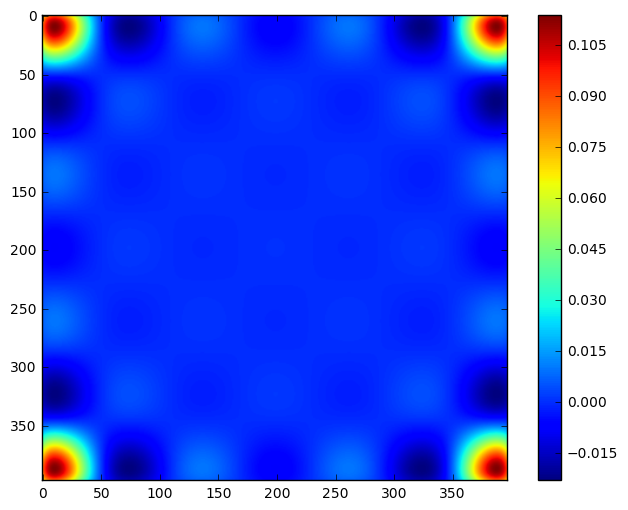

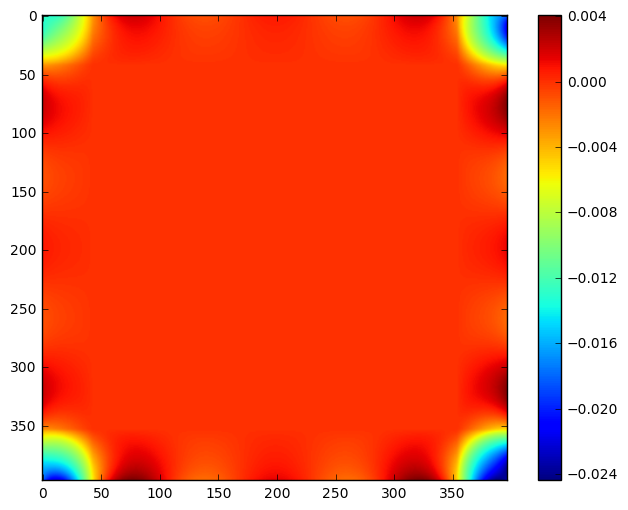

In [234]:
ti=nt-1
spc=5
plt.figure()
plt.imshow(u3.data[ti, 2*spc:-2*spc, 2*spc:-2*spc])
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(analy3.data[ti, 2*spc:-2*spc, 2*spc:-2*spc])
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(u3.data[ti, 2*spc:-2*spc, 2*spc:-2*spc] - analy3.data[ti, 2*spc:-2*spc, 2*spc:-2*spc])
plt.colorbar()
plt.show()

In [235]:
np.max(np.fabs((u3.data[nt-1, 2*spc:-2*spc, 2*spc:-2*spc] - analy3.data[nt-1, 2*spc:-2*spc, 2*spc:-2*spc])))

0.024390625654716405